# Reporte de práctica 8: Análisis de varianza y de componentes principales

En esta práctica haremos análisis de varianza(ANOVA) a los datos de las prácticas anteriores.

## Objetivo

- Realizar un análisis de varianza (ANOVA)
- Realizar un análisis de componentes principales (PCA)

### Lectura de datos

Se procede a abrir los datos de la práctica anterior.

In [1]:
import statsmodels.api as sm
from numpy import isnan
import pandas as pd
cine = pd.read_excel('https://raw.githubusercontent.com/SamatarouKami/CIENCIA_DE_DATOS/master/2018.xlsx', index_col=None, header=0, sheet_name=0)
cine = cine[['Categoria','Edad','Pais', 'Titulo','Genero', 'Duracion', 'Marca','Referencia','Dias','Marcas','Personas','Sinopsis']]

cine = cine.dropna()

print(len(cine))

266


## ANOVA

El Análisis de varianza (ANOVA) es una herramienta para cuantificar sí o no una variable o factor tiene un efecto estadísticamente significativo en una variable de interés. Se realiza a partir de la salida del modelo de regresión que se obtiene con otra versión de ols.

Hay tres tipos de ANOVA, cuyo uso depende de sí o no se espera contar con interacciones entre las variables de entrada y sí o lo los datos son balanceados.

La hipótesis nula en ANOVA es que no haya diferencias; si el valor p de una variable es menor a la significación establecida (para nosotros 0.05 está bien; con muchos datos muy precisos es mejor usar 0.01), entonces se rechaza la hipótesis nula, concluyendo que esa variable sí tiene un efecto estadísticamente significativo.


Se analiza si las personas están relacionadas con la categoría, género y los días de grabación del filme.

In [2]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

m = ols('Personas ~ Categoria + Genero + Dias', data = cine).fit() 
a = sm.stats.anova_lm(m, typ = 2)
print(a)
n = len(a)
alpha = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a.index[i], "" if a['PR(>F)'][i] < alpha else "NO "))

                 sum_sq     df         F        PR(>F)
Categoria   2281.950763    5.0  8.659926  1.366205e-07
Genero       320.198519    8.0  0.759464  6.388620e-01
Dias         205.450311    1.0  3.898385  4.942439e-02
Residual   13280.751254  252.0       NaN           NaN
Categoria es significativo
Genero NO es significativo
Dias es significativo
Residual NO es significativo


Podemos ver que los días y categoría si son significativos, pero el residual es muy grande. Agreguemos el factor  "Duración" para ver su interacción con estos factores.

In [3]:
from statsmodels.formula.api import ols
import statsmodels.api as sm

m = ols('Personas ~ Categoria  * Duracion + Genero * Duracion + Dias * Duracion ', data = cine).fit() 
a = sm.stats.anova_lm(m, typ = 2)
print(a)
n = len(a)
alpha = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a.index[i], "" if a['PR(>F)'][i] < alpha else "NO "))

                          sum_sq     df          F        PR(>F)
Categoria            2204.147359    5.0   8.696252  1.371812e-07
Genero                292.599339    8.0   0.721514  6.724490e-01
Duracion              703.101072    1.0  13.870089  2.446383e-04
Categoria:Duracion    203.155195    5.0   0.801529  5.495267e-01
Genero:Duracion       364.989594    8.0   0.900020  5.171006e-01
Dias                  237.026122    1.0   4.675819  3.158689e-02
Dias:Duracion          33.485104    1.0   0.660561  4.171741e-01
Residual            12064.670548  238.0        NaN           NaN
Categoria es significativo
Genero NO es significativo
Duracion es significativo
Categoria:Duracion NO es significativo
Genero:Duracion NO es significativo
Dias es significativo
Dias:Duracion NO es significativo
Residual NO es significativo


Ahora la Duración tomó significación. Lo único significativo, sin interacciones, siguen siendo Categoría y Días. Revisemos por las interacciones.

In [4]:
m = ols('Personas ~ Categoria  * Dias + Dias * Duracion + Duracion * Categoria', data = cine).fit() 
a = sm.stats.anova_lm(m, typ = 2)
print(a)
n = len(a)
alpha = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a.index[i], "" if a['PR(>F)'][i] < alpha else "NO "))

                          sum_sq     df          F        PR(>F)
Categoria            2611.588301    5.0  10.456200  4.079372e-09
Dias                  270.898309    1.0   5.423073  2.067991e-02
Categoria:Dias        319.177406    5.0   1.277913  2.739514e-01
Duracion              684.351795    1.0  13.699938  2.644666e-04
Duracion:Categoria    135.880382    5.0   0.544034  7.428013e-01
Dias:Duracion           0.926056    1.0   0.018539  8.918085e-01
Residual            12338.369436  247.0        NaN           NaN
Categoria es significativo
Dias es significativo
Categoria:Dias NO es significativo
Duracion es significativo
Duracion:Categoria NO es significativo
Dias:Duracion NO es significativo
Residual NO es significativo


Se puede observar que a pesar de ser significativas independientemente, al interactuar no significan nada.

## PCA

El [análisis de componentes principales (PCA)](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60) sirve para reducir múltiples variable de entrada en una menor cantidad de variables para modelar la variable de interés. Funciona con datos numéricos que primero se normalizan y luego se proyectan a una dimensión deseada.

Se aplica un PCA sobre los datos, 

    * Primero nos deshacemos de las columnas que no conviene codificar con números.
    * Luego categorizamos las que sí convienen.
    * Las reemplazamos con los números de las categorías.
    * Estandarizamos rangos.
    * Probamos reducción proyectando los datos a dos dimensiones.
    * Visualizamos el resultado.


In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

print('Qué tenemos')
print(cine.columns)
      
xVars = ['Edad','Duracion', 'Marcas', 'Categoria']

cat = pd.Categorical(cine.Categoria)
cine['Categoria'] = cat.codes

#print(cine.Personas.mean())
#print(cine.Dias.mean())

#d.CF2op = d.CF2op.replace(nan, 0) # para no perder a los que pasaron en primera
#d = d.dropna() # podemos únicamente usar los renglones que contienen todas las respuestas
d = cine
d = d.dropna()
x = d.loc[:, xVars].values
x = StandardScaler().fit_transform(x)
y1 = d.loc[:,['Personas']].values
y2 = d.loc[:,['Dias']].values
k = 2 # dimensiones deseadas
pca = PCA(n_components = k)
cd = pd.DataFrame(data = pca.fit_transform(x), columns = ['comp_{:d}'.format(i) for i in range(k)])
cd['Personas'] = y1
cd['Dias'] = y2
ordenado = pd.DataFrame.sort_values(cd, ['Personas'], ascending = False)
display(cd.head(10))



Qué tenemos
Index(['Categoria', 'Edad', 'Pais', 'Titulo', 'Genero', 'Duracion', 'Marca',
       'Referencia', 'Dias', 'Marcas', 'Personas', 'Sinopsis'],
      dtype='object')


,comp_0,comp_1,Personas,Dias
0,-0.093040,0.634029,4,7
1,-0.330257,1.187852,7,8
2,-0.383991,1.564923,11,16
3,0.038034,-1.231784,5,3
4,-0.086769,0.520188,13,90
5,-0.262758,1.181875,12,30
6,-0.269580,0.902898,6,5
7,-0.035894,-1.288132,1,7
8,0.061712,-1.343304,16,10
9,-0.078685,0.582270,9,20


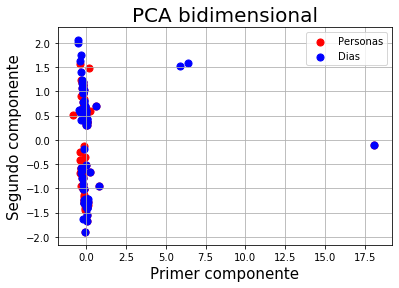

In [6]:
import matplotlib.pyplot as plt
                                                                                                                  
d = cd
n = len(d)
pri = d.Personas >= 10
seg = d.Dias >= 28
#ter = ~ (pri | seg)
n == sum(pri) + sum(seg) #+ sum(ter)

#print(sum(pri), sum(seg), sum(ter))

plt.title('PCA bidimensional', fontsize = 20)
plt.xlabel('Primer componente', fontsize = 15)
plt.ylabel('Segundo componente', fontsize = 15)
plt.scatter(d.loc[pri].comp_0, d.loc[pri].comp_1, c = 'r', s = 50)
plt.scatter(d.loc[seg].comp_0, d.loc[seg].comp_1, c = 'b', s = 50)
#plt.scatter(d.loc[ter].comp_0, d.loc[ter].comp_1, c = 'r', s = 50)
plt.legend(['Personas', 'Dias'])
plt.grid()

## Conclusión

En ANOVA se pudo observar que aunque individualmente los datos sean significativos, cuando interactúan no lo son. En el PCA se modeló en para las variables Personas y Días en función de la Edad del participante, la duración y categoría del filme y las marcas de grabación. Con esta información disponible, en dos dimensiones, no se pueden separar los la cantidad de personas con los días de grabación.

--05 de junio 2019-- Luis Angel Gutiérrez Rodríguez 1484412